In [1]:
from IPython.display import display, Math, Latex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA

### Aufgabe 5.6 Clusteranalyse Siebenkampf
Wir analysieren Daten zum $\textbf{Siebenkampf}$ aus den Olympischen Spielen und Weltmeisterschaften der Jahre 1984 bis 2013.

In [2]:
path="/Users/julia/Desktop/Lehre/2025_WiSe/Multivariate_Analysemethoden/2024_SoSe_Unterlagen/data"

#### 0 Importieren des Datensatzes

In [3]:
sieben=pd.read_csv(path+"/siebenkampf.csv",sep=";",index_col=0)

In [4]:
disziplinen = ["Hochsprung", "Weitsprung", 
               "Zeit_100m_Huerden", "Zeit_200m_Lauf", "Zeit_800m_Lauf_Sekunden", 
               "Kugelstoßen", "Speerwurf"]
sieben_dis = sieben[disziplinen]

#### 1 Datenaufbereitung und Standardisierung

In [5]:
# Wie in Aufgabe 3.8: String -> Float
sieben_dis_numeric=sieben_dis.copy()
for column in sieben_dis.columns:
    sieben_dis_numeric[column]=sieben_dis[column].str.replace(',','.').astype(float)

In [6]:
# Wir filtern die in Aufgabe 3.8 entdeckten Ausreißer (Datenfehler), da diese das Clustering verzerren würden
sieben_dis_numeric1 = sieben_dis_numeric[(sieben_dis_numeric["Hochsprung"] != 0) & 
                         (sieben_dis_numeric["Zeit_100m_Huerden"] <= 15) & 
                         (sieben_dis_numeric["Zeit_200m_Lauf"] <= 30)]

In [7]:
# Variablen umdrehen, sodass die Richtung immer gleich ist 
# größer ist besser: "Hochsprung", "Weitsprung", "Kugelstoßen", "Speerwurf"
# kleiner ist besser: "Zeit_100m_Huerden", "Zeit_200m_Lauf", "Zeit_800m_Lauf_Sekunden" 
    ## -> die Variablen umdrehen, sodass größer immer besser ist
sieben_dis_numeric2=sieben_dis_numeric1.copy()
sieben_dis_numeric2["Zeit_100m_Huerden"] = sieben_dis_numeric1["Zeit_100m_Huerden"].max() - sieben_dis_numeric1["Zeit_100m_Huerden"]
sieben_dis_numeric2["Zeit_200m_Lauf"] = sieben_dis_numeric1["Zeit_200m_Lauf"].max() - sieben_dis_numeric1["Zeit_200m_Lauf"]
sieben_dis_numeric2["Zeit_800m_Lauf_Sekunden"] = sieben_dis_numeric1["Zeit_800m_Lauf_Sekunden"].max() - sieben_dis_numeric1["Zeit_800m_Lauf_Sekunden"]

In [8]:
# Wir standardisieren die Daten, um die Werteskalen der Variablen anzugleichen
sieben_dis_numeric2_stand = sieben_dis_numeric2.copy()
sieben_dis_numeric2_stand[disziplinen] = StandardScaler().fit_transform(sieben_dis_numeric2[disziplinen])

#sieben_dis_numeric2_stand.to_csv("../data/sieben_groesser_besser.csv", sep=';', index=False)

In [9]:
sieben_dis_numeric2_stand.describe()

,Hochsprung,Weitsprung,Zeit_100m_Huerden,Zeit_200m_Lauf,Zeit_800m_Lauf_Sekunden,Kugelstoßen,Speerwurf
count,2.070000e+02,2.070000e+02,2.070000e+02,2.070000e+02,2.070000e+02,2.070000e+02,2.070000e+02
mean,-4.846365e-15,1.267371e-15,3.432574e-17,-2.145359e-16,1.716287e-17,-4.462346e-16,-1.587565e-15
std,1.002424e+00,1.002424e+00,1.002424e+00,1.002424e+00,1.002424e+00,1.002424e+00,1.002424e+00
min,-3.750481e+00,-3.421715e+00,-3.662322e+00,-2.568778e+00,-3.468062e+00,-2.372159e+00,-2.635628e+00
25%,-5.668358e-01,-6.664642e-01,-5.511398e-01,-6.811301e-01,-7.114910e-01,-6.938190e-01,-5.898475e-01
50%,-3.622827e-02,-8.759096e-03,4.428443e-03,6.203841e-02,4.516903e-02,-2.159246e-02,-4.218267e-02
75%,4.943792e-01,6.133944e-01,6.016643e-01,5.822564e-01,6.842557e-01,5.526938e-01,6.349489e-01
max,2.439940e+00,3.404197e+00,2.726713e+00,2.603675e+00,2.245304e+00,2.863194e+00,2.388915e+00


#### 2 Kovarianz und Korrelation

                         Hochsprung  Weitsprung  Zeit_100m_Huerden  \
Hochsprung                 1.004854    0.305351           0.038231   
Weitsprung                 0.305351    1.004854           0.448711   
Zeit_100m_Huerden          0.038231    0.448711           1.004854   
Zeit_200m_Lauf             0.074986    0.463562           0.610120   
Zeit_800m_Lauf_Sekunden   -0.013422    0.103246           0.253790   
Kugelstoßen               -0.089287   -0.003836          -0.113332   
Speerwurf                  0.040232   -0.150356          -0.108894   

                         Zeit_200m_Lauf  Zeit_800m_Lauf_Sekunden  Kugelstoßen  \
Hochsprung                     0.074986                -0.013422    -0.089287   
Weitsprung                     0.463562                 0.103246    -0.003836   
Zeit_100m_Huerden              0.610120                 0.253790    -0.113332   
Zeit_200m_Lauf                 1.004854                 0.413336    -0.121984   
Zeit_800m_Lauf_Sekunden        0.4

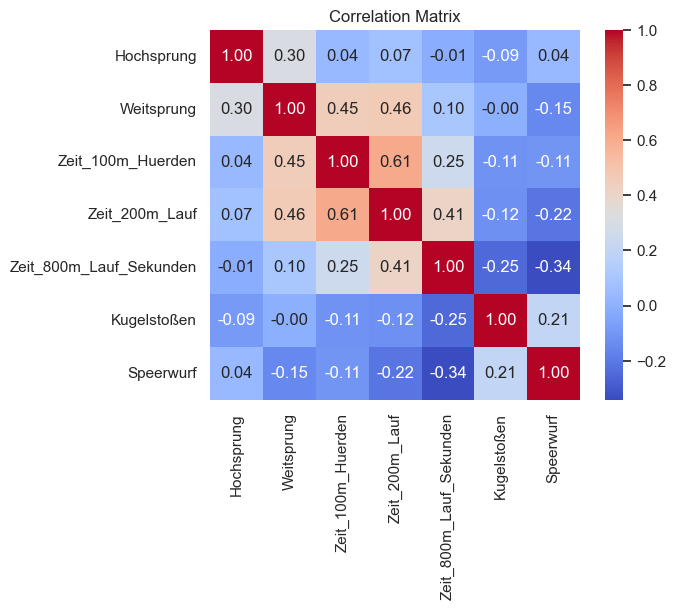

In [10]:
# Kovarianz- und Korrelationsmatrix
cov_matrix = sieben_dis_numeric2_stand.cov()
cor_matrix = sieben_dis_numeric2_stand.corr()

# Kovarianz- und Korrelationsmatrix sind identisch für standardisierte Daten
print(cov_matrix)
print(cor_matrix)

# Plot der Korrelationsmatrix
sns.set(style="white")
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix')
plt.show()

#### 3 K-Means Clustering

##### 3.1 4-Means Clustering

In [11]:
kmeans_4 = KMeans(n_clusters=4, n_init=25)
kmeans_4.fit(sieben_dis_numeric2_stand)

,n_clusters,4
,init,'k-means++'
,n_init,25
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


##### 3.2 Visualisierung mit PCA

In [12]:
pca = PCA(n_components=2) # 2-D visualization
sieben_pca = pca.fit_transform(sieben_dis_numeric2_stand)
# Create a DataFrame for PCA results (i.e. score-vector of datapoints w.r.t principal components)
pca_df = pd.DataFrame(sieben_pca, columns=['PC1', 'PC2'], index=sieben_dis_numeric2_stand.index)

In [13]:
pca_df['Cluster_4means'] = kmeans_4.labels_

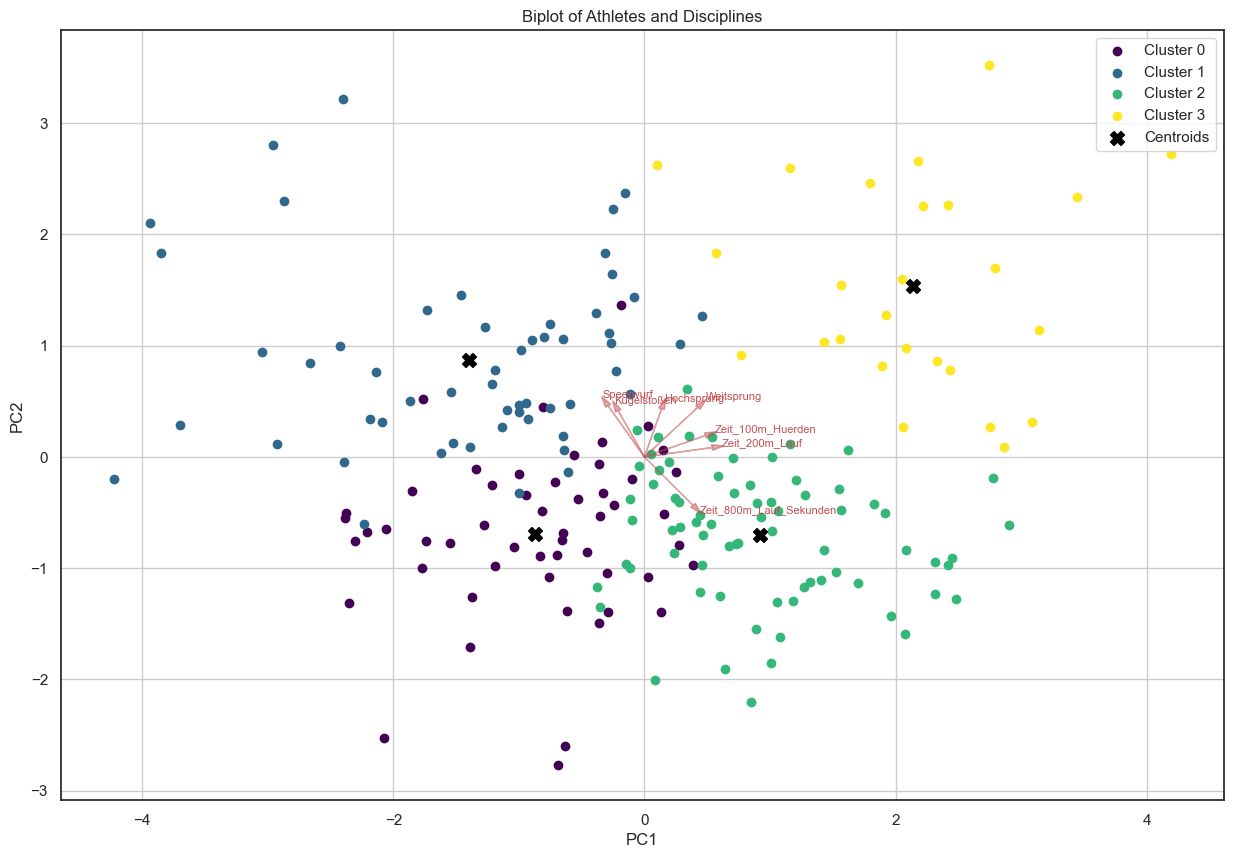

In [15]:
# Biplot Visualization
plt.figure(figsize=(15, 10))

# Plot datapoints with different colors for different clusters
clusters = np.unique(pca_df['Cluster_4means'])
colors = plt.get_cmap('viridis', len(clusters))

for cluster in clusters:
    cluster_data = pca_df[pca_df['Cluster_4means'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], color=colors(cluster), label=f'Cluster {cluster}')

# Plot cluster centroids
centroids = pd.DataFrame(kmeans_4.cluster_centers_, columns=sieben_dis_numeric2_stand.columns)
centroids_pca=pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='black', marker='X', label='Centroids')

# Plot arrows for principal components
for i, var in enumerate(disziplinen):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
    plt.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, var, color='r', fontsize=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of Athletes and Disciplines')
plt.grid(True)
plt.legend()
plt.show()

##### 3.3 Scree-Plot und Elbow-Kriterium

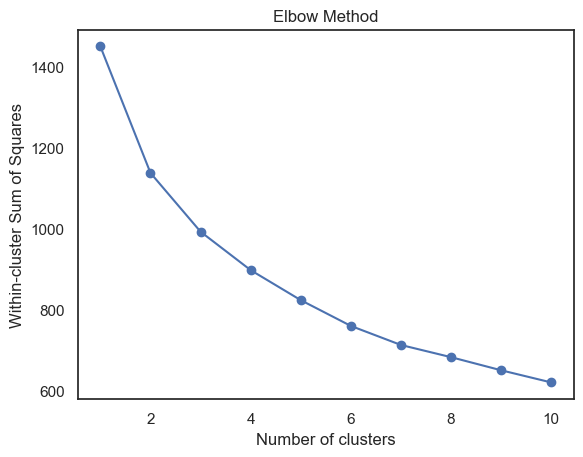

In [16]:
# Determine optimal number of clusters using the elbow method
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=25)
    kmeans.fit(sieben_dis_numeric2_stand)
    wss.append(kmeans.inertia_)

plt.plot(range(1, 11), wss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()

##### 3.4 Silhouette Analysis

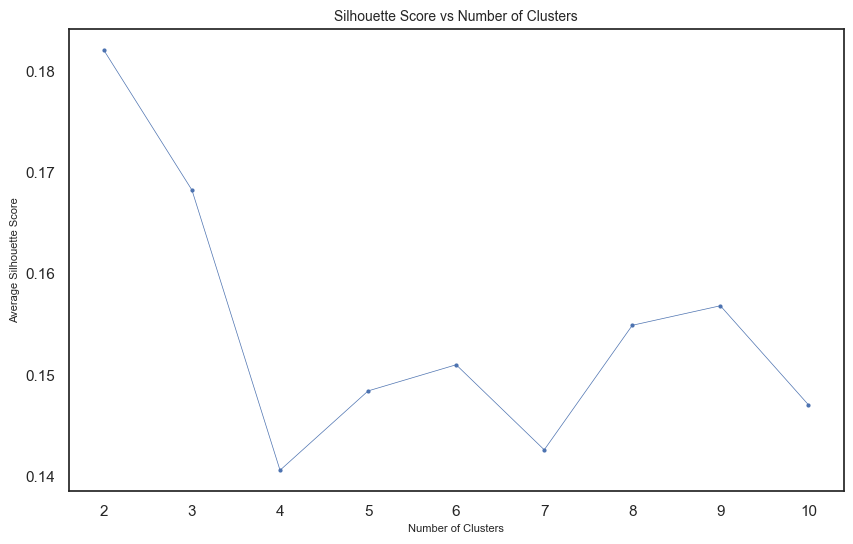

In [17]:
silhouette_scores = []

# Perform silhouette analysis for different numbers of clusters
for n_clusters in range(1, 11):
    clusterer = KMeans(n_clusters=n_clusters, n_init=20)
    cluster_labels = clusterer.fit_predict(sieben_dis_numeric2_stand)
    
    # Calculate silhouette scores
    if n_clusters > 1:
        silhouette_avg = silhouette_score(sieben_dis_numeric2_stand, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(np.nan)  # Silhouette score is not defined for n_clusters=1

# Plot average silhouette scores for clusters from 1 to 10
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), silhouette_scores, linewidth=0.5, marker='o', markersize=2)
plt.title('Silhouette Score vs Number of Clusters',fontsize=10, fontweight='normal')
plt.xlabel('Number of Clusters', fontsize=8, fontweight='light')
plt.ylabel('Average Silhouette Score', fontsize=8, fontweight='light')
#plt.grid(True)
plt.show()


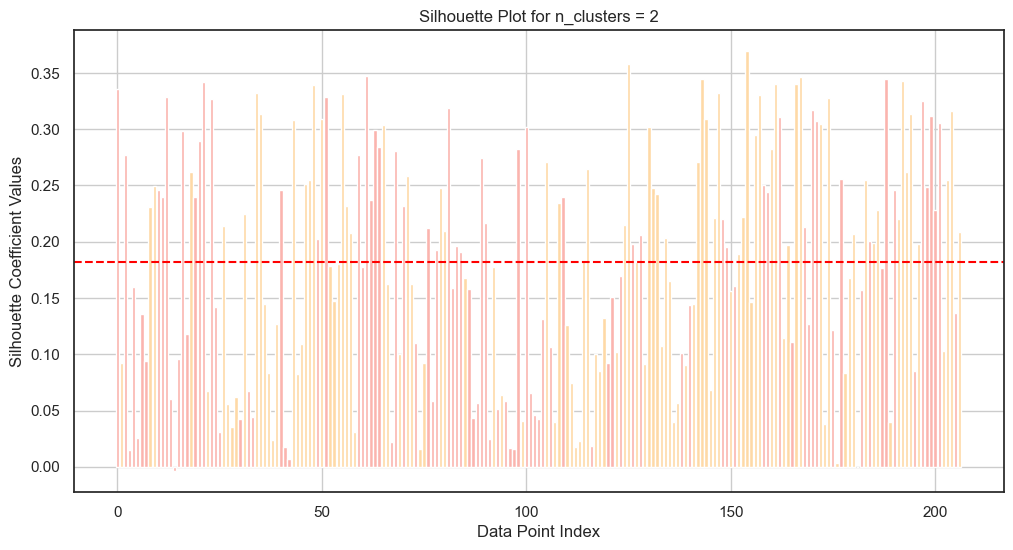

In [18]:
for n_clusters in [2]:
    clusterer = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    cluster_labels = clusterer.fit_predict(sieben_dis_numeric2_stand)
    silhouette_values = silhouette_samples(sieben_dis_numeric2_stand, cluster_labels)
    
    plt.figure(figsize=(12, 6))
    
    # Plot silhouette scores as bars with colors based on cluster labels
    colors = plt.cm.Pastel1(cluster_labels.astype(float) / n_clusters)
    plt.bar(range(len(silhouette_values)), silhouette_values,color=colors)
    
    # Add index of the data points to the x-axis
    #plt.xticks(range(len(silhouette_values)), sieben_dis_numeric2_stand.index, rotation=90)
    
    silhouette_avg = np.mean(silhouette_values)  # Calculate the average silhouette score
    
    plt.title(f'Silhouette Plot for n_clusters = {n_clusters}')
    plt.ylabel('Silhouette Coefficient Values')
    plt.xlabel('Data Point Index')
    plt.axhline(y=silhouette_avg, color="red", linestyle="--")
    plt.grid(True)
    plt.show()


#### 4 Hierarchisches Clustering

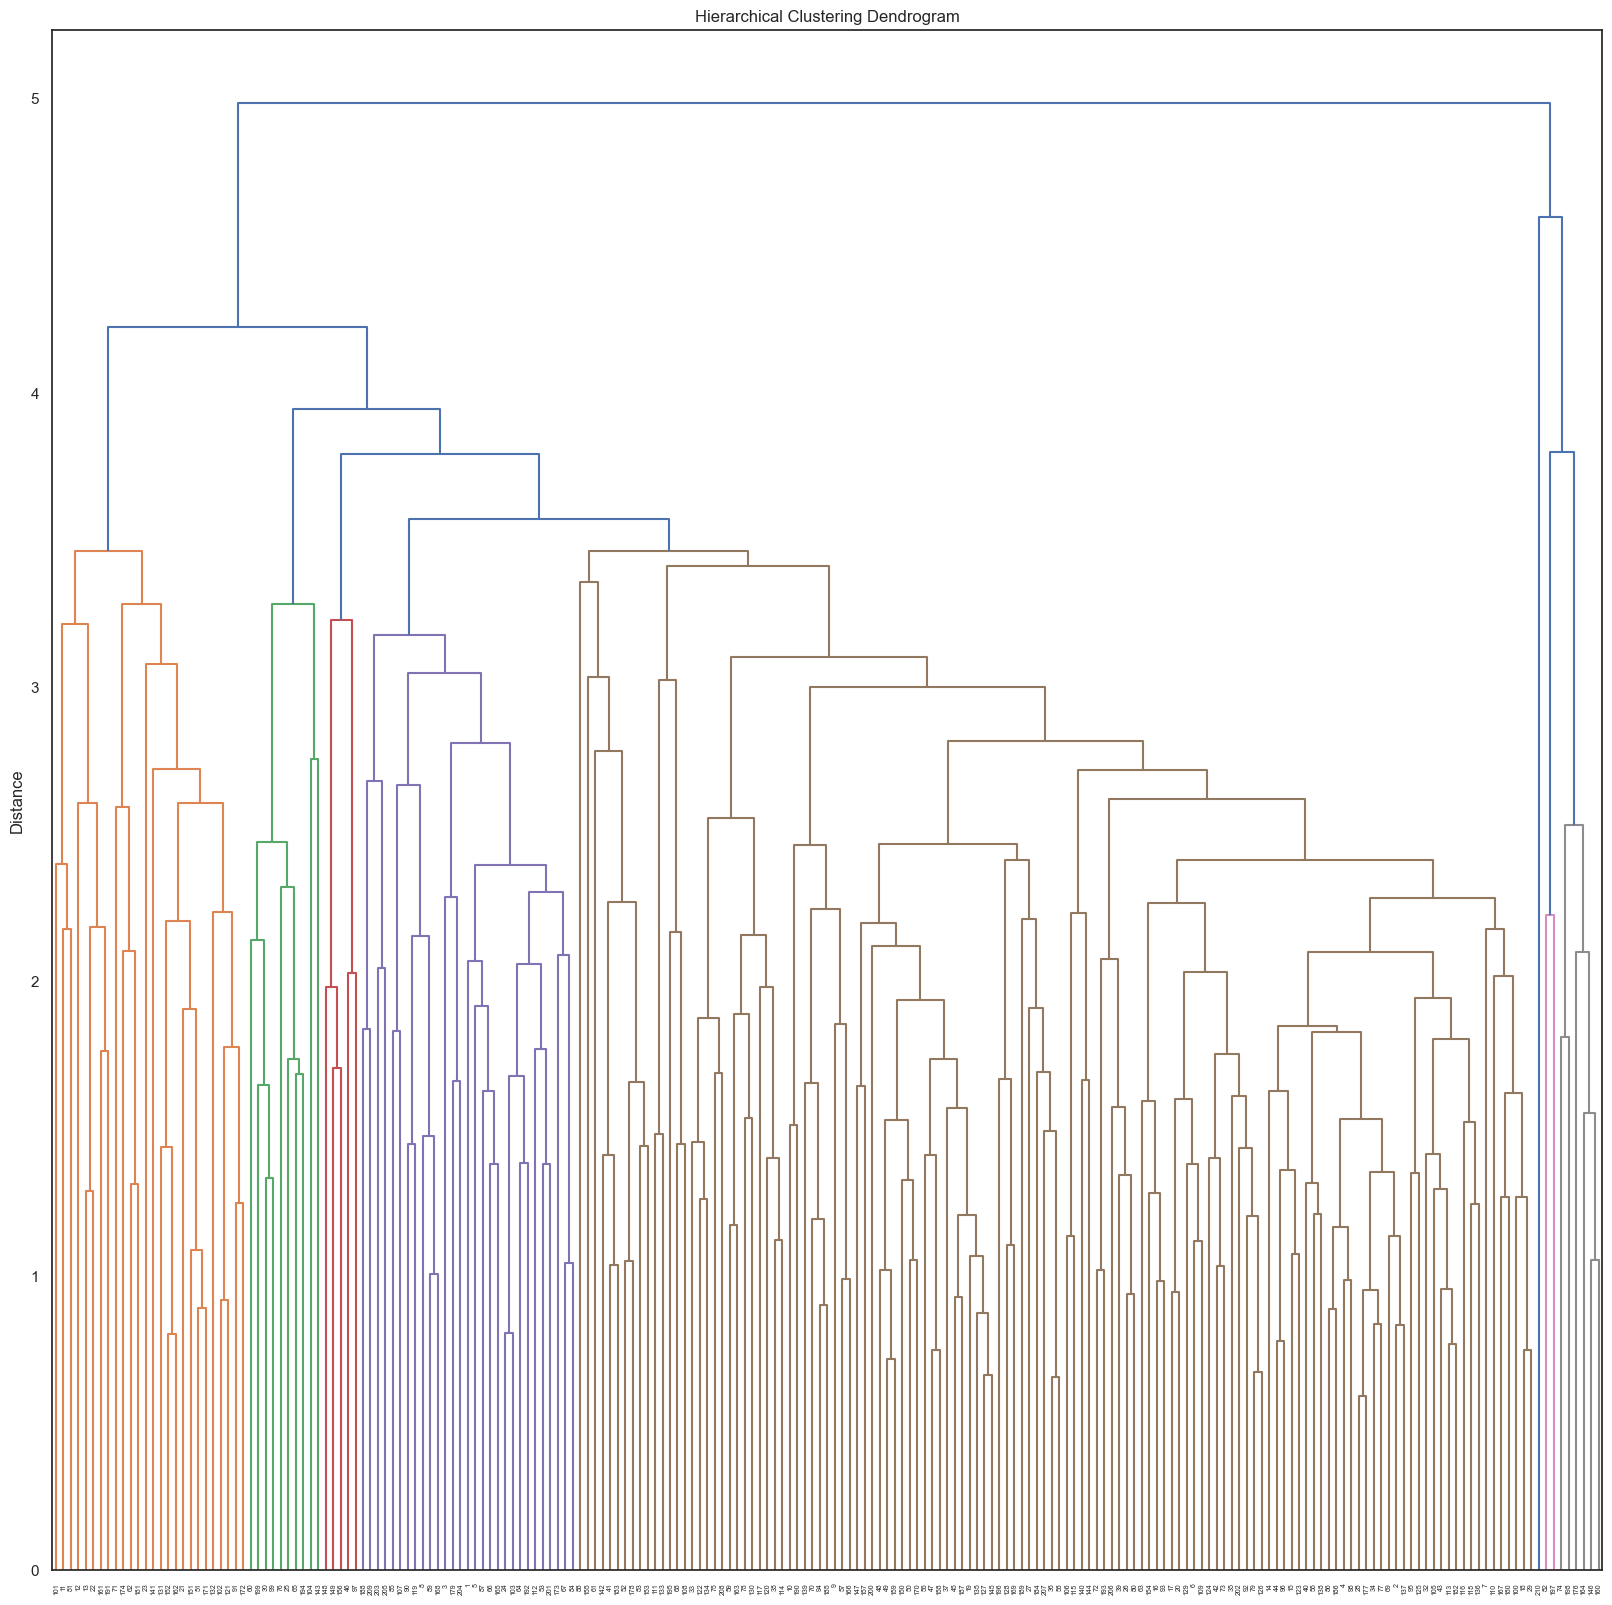

In [19]:
# Hierarchical clustering
plt.figure(figsize=(20,20))
distance = linkage(sieben_dis_numeric2_stand, method='average')
dendrogram(distance, labels=sieben_dis_numeric2_stand.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()